<a href="https://colab.research.google.com/github/johntzwei/metric-statistical-advantage/blob/main/human_comparison_summeval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pickle
import itertools
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from multiprocessing import Pool
import seaborn as sns
sns.set_context('paper', font_scale=0.73)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import matplotlib.pyplot as plt
import pdb

# Data

In [ ]:
!pip install gdown
!gdown --id 1bv6zJdXbvUxMCmWXSHW3-GicPPWN9f1F

Downloading...
From: https://drive.google.com/uc?id=1bv6zJdXbvUxMCmWXSHW3-GicPPWN9f1F
To: /home/johnny/summeval_flat.pkl
100%|██████████████████████████████████████| 2.06M/2.06M [00:00<00:00, 10.9MB/s]


In [ ]:
df = pickle.load(open('summeval_flat.pkl', 'rb'))
df.head(1)

,id,output,reference_1,system,r11_rouge_4_f_score,r11_meteor,r11_rouge_we_1_f,r11_bert_score,r1_supert,type,score
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,Andros Townsend an 83rd minute sub in Tottenha...,M11,0.00185,0.220548,0.306888,0.399867,0.508232,expert,2.25


In [ ]:
# from variance_analysis_wmt.ipynb
pooled_vars = json.loads('{"expert": 0.0859722222222225, "turker": 0.22594999999999998}')
total_vars = json.loads('{"expert": 0.5144329560745868, "turker": 0.5551246093750001}')

In [ ]:
ratios = {}
ratios['turker'] = total_vars['turker'] / (total_vars['turker'] - pooled_vars['turker'])
ratios['expert'] = total_vars['expert'] / (total_vars['expert'] - pooled_vars['expert'])

ratios

{'turker': 1.6864138167552125, 'expert': 1.2006536782244464}

# Human comparisons

In [ ]:
# adopted from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_noise_decomposition(metric_results, human_results, no_bias=False):
    main_predictions = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x)),
                                           axis=0,
                                           arr=metric_results)

    optimal_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=human_results)
    
    if no_bias:
        main_predictions = optimal_predictions
    
    avg_expected_loss = (human_results != metric_results).mean()

    noises = (human_results != optimal_predictions).mean(axis=0)
    probs = (metric_results == optimal_predictions).mean(axis=0)

    avg_noise_contrib = ((2 * probs - 1) * noises).mean()

    avg_bias_contrib = (main_predictions != optimal_predictions).mean()

    signs = (main_predictions == optimal_predictions).astype(np.int64) * 2 - 1
    variances = (metric_results != main_predictions).mean(axis=0)
    avg_var_contrib = (signs * variances).mean()

    return avg_expected_loss, avg_bias_contrib, avg_var_contrib, avg_noise_contrib

In [ ]:
def pairs(x):
    systems = x.system.unique()
    for i, j in itertools.combinations(systems, 2):
        yield i, j
        
all_pairs = list(pairs(df))
all_pairs[:10]

[('M11', 'M13'),
 ('M11', 'M1'),
 ('M11', 'M14'),
 ('M11', 'M15'),
 ('M11', 'M12'),
 ('M11', 'M5'),
 ('M11', 'M17'),
 ('M11', 'M20'),
 ('M11', 'M23'),
 ('M11', 'M2')]

In [ ]:
# get pairwise predictions from the scoring of each system
# in the form of a (num_pairs,) length vector, where 1 or 0 denotes the ordering of that pair
def get_preds(all_pairs, scores):
    preds = np.zeros(len(all_pairs))
    if type(scores) == type({}):
        for ii, (i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores[i] - scores[j] > 0 else 0
    else:
        for ii, (i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores.loc[i] - scores.loc[j] > 0 else 0
            
    return preds

In [ ]:
groupby_cached = [ (i, pd.DataFrame(g)) for i, g in df.groupby(['system']) ]
groupby_labels = [ i[0] for i in groupby_cached ]

### Experimental parameters

In [ ]:
NUM_WORKERS = 12
NUM_TRIALS = 10000
CHUNKSIZE = 10
METRICS = range(50, 301, 50)

In [ ]:
SEED = 0
random_state = np.random.RandomState(SEED)

### Bootstrap experiments

In [ ]:
def f(x):
    n, ratios, seed = x
    this_rs = np.random.RandomState(seed)
    
    groups = [ g.sample(frac=1, replace=True, random_state=this_rs) for i, g in groupby_cached ]
    observed_means = [ g['score'].mean() for g in groups ]
    observed_means = { label:mean for label, mean in zip(groupby_labels, observed_means) }
    
    # humans
    groups = [ g.sample(n=n, replace=True, random_state=this_rs) for i, g in groupby_cached ]
    human_means = [ g['score'].mean() for g in groups ]
    human_means = { label:mean for label, mean in zip(groupby_labels, human_means) }

    # theoretical
    groups = [ g.sample(n=int(n*ratios['expert']), replace=True, random_state=this_rs) for i, g in groupby_cached ]
    pa_means = [ g['score'].mean() for g in groups ]
    pa_means = { label:mean for label, mean in zip(groupby_labels, pa_means) }

    return get_preds(all_pairs, observed_means), get_preds(all_pairs, human_means), get_preds(all_pairs, pa_means)

results = {}
with Pool(NUM_WORKERS) as p:
    for metric in tqdm(METRICS):
        it = tqdm(p.imap_unordered(f, [(metric, ratios, random_state.randint(0, 2**32 - 1)) for i in range(0, NUM_TRIALS)],
                                   chunksize=CHUNKSIZE), total=NUM_TRIALS)
        output = list(it)

        label_results = np.array([ i[0] for i in output ], dtype=np.int64)
        human_results = np.array([ i[1] for i in output ], dtype=np.int64)
        pa_results = np.array([ i[2] for i in output ], dtype=np.int64)
        
        results[metric] = (bias_var_noise_decomposition(human_results, label_results, no_bias=True),
                          bias_var_noise_decomposition(pa_results, label_results, no_bias=True))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# Results

### Graph

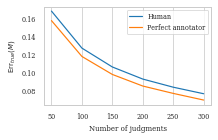

In [ ]:
x = list(METRICS)
y = [results[i][0][2] for i in x]
y_pa = [results[i][1][2] for i in x]

plt.figure(figsize=(3, 1.8))
ax = sns.lineplot(x=x, y=y, label='Human')
sns.lineplot(x=x, y=y_pa, label='Perfect annotator')
ax.set(xlabel='Number of judgments', ylabel='$\\mathrm{Err}_{true}(M)$')
ax.yaxis.grid(False)
ax.legend(loc='upper right')
plt.savefig('human_comparison_summeval.pdf', bbox_inches='tight')